In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import scipy as sc
from scipy.signal import savgol_filter
from scipy.signal import bessel
from scipy import signal
import importlib
import math
import shutil

%matplotlib inline
plt.rcParams['figure.dpi'] = 150

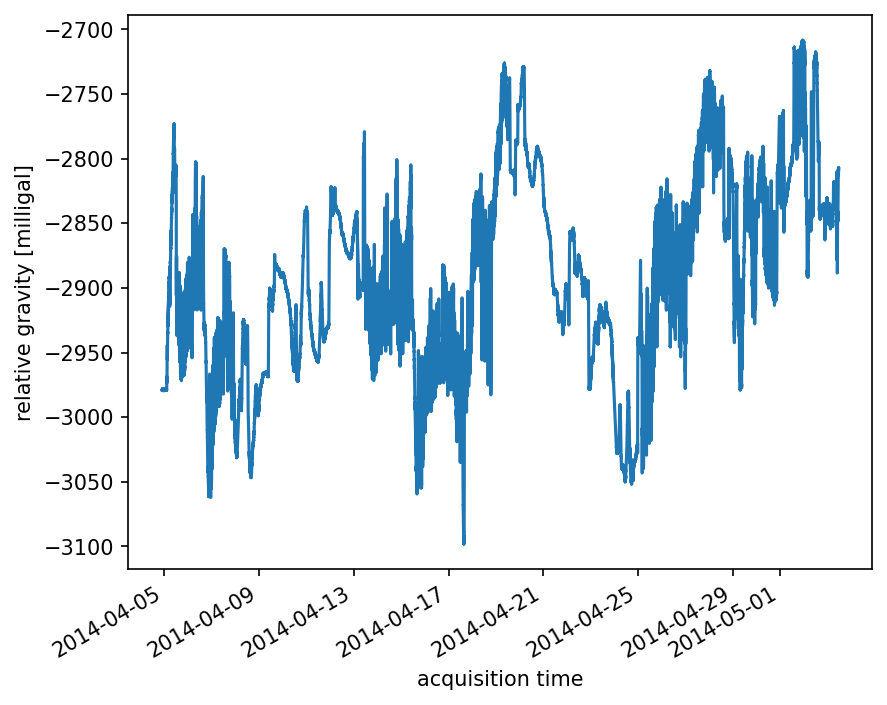

In [3]:
file = 'C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//test3//201400080045-KSS-AT_KSS31M.gravi.nc'
with xr.open_dataset(file) as ds:
    gravity = ds.gravity
    gravity.plot()

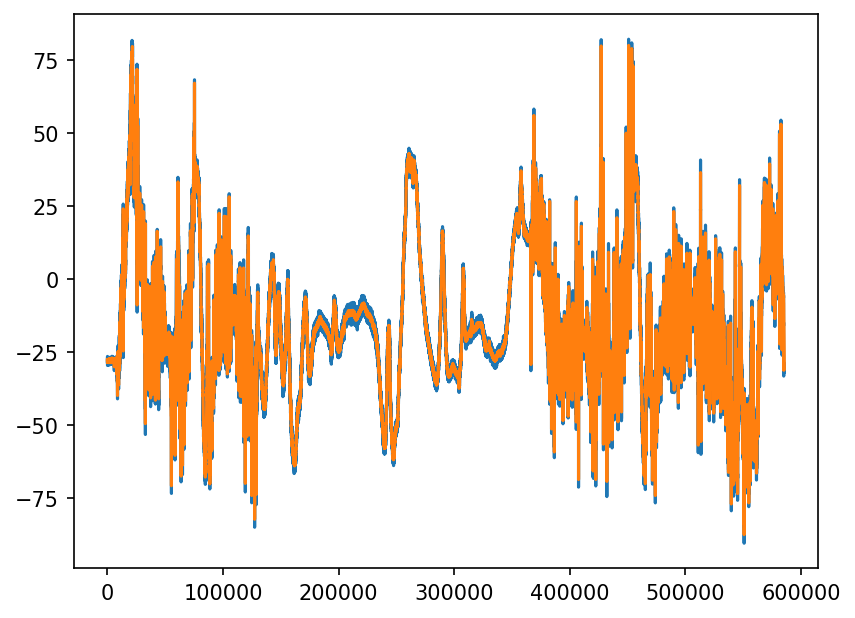

In [13]:
arr = np.fromfile('C:\\Users\\gbillant\\AppData\\Local\\Temp\\LargeArray_ce_14350855846349735276.tmp')
plt.plot(arr)
filtered = savgol_filter(arr, 51, 2)
plt.plot(filtered)

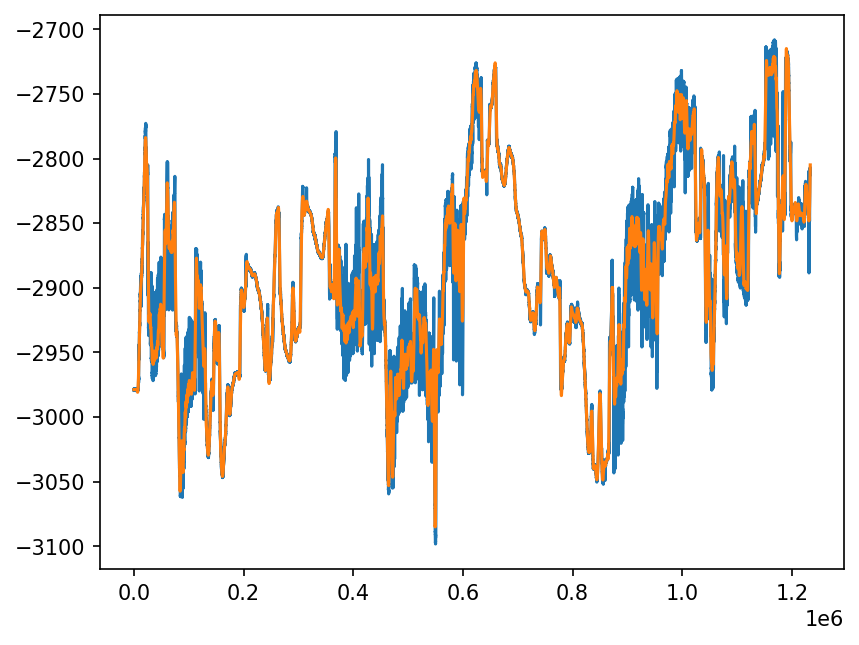

In [7]:

file = "C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//test3//201400080045-KSS-AT_KSS31M_cut.gravi.nc"

yhat = savgol_filter(gravity, 5001, 2) # window size 51, polynomial order 3
plt.plot(gravity.values)
plt.plot(yhat)

#output_file = file.replace(".gravi.nc","_17h48.gravi.nc")
#shutil.copy(file, output_file)



#with nc.Dataset(output_file, "w") as ncFile:
    #print(ncFile)
    #smoothed_gravity = ncFile.createVariable('/smoothed_gravity', np.float32, ('time',))
    #smoothed_gravity.units = 'mgal'
    #smoothed_gravity.long_name = 'smoothed gravity'
    #ncFile.close()
#ncFile.close()


In [222]:
ncFile = nc.Dataset(output_file, "w")
ncFile.close()

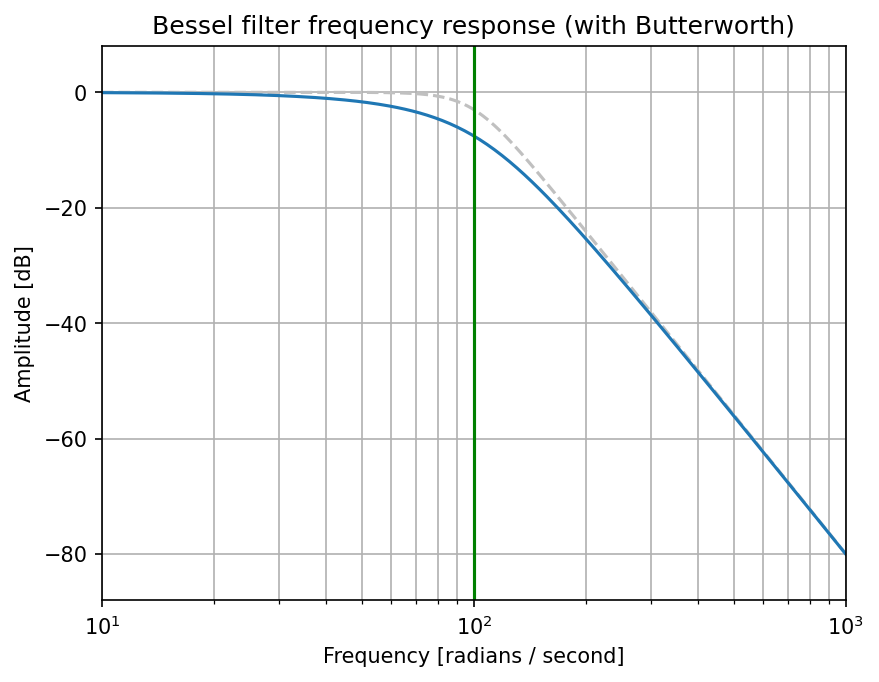

In [30]:
b, a = signal.butter(4, 100, 'low', analog=True)
w, h = signal.freqs(b, a)
plt.plot(w, 20 * np.log10(np.abs(h)), color='silver', ls='dashed')

b, a = signal.bessel(4, 100, 'low', analog=True)
w, h = signal.freqs(b, a)
plt.plot(w, 20 * np.log10(np.abs(h)))

plt.xscale('log')
plt.title('Bessel filter frequency response (with Butterworth)')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

In [92]:
1/175

0.005714285714285714

In [153]:
b_bessel, a_bessel = signal.bessel(2, (1/175)*2*math.pi, btype ='low')#, analog=True)
print(a_bessel)
print(b_bessel)

[ 1.         -1.81078157  0.82236207]
[0.00289513 0.00579025 0.00289513]


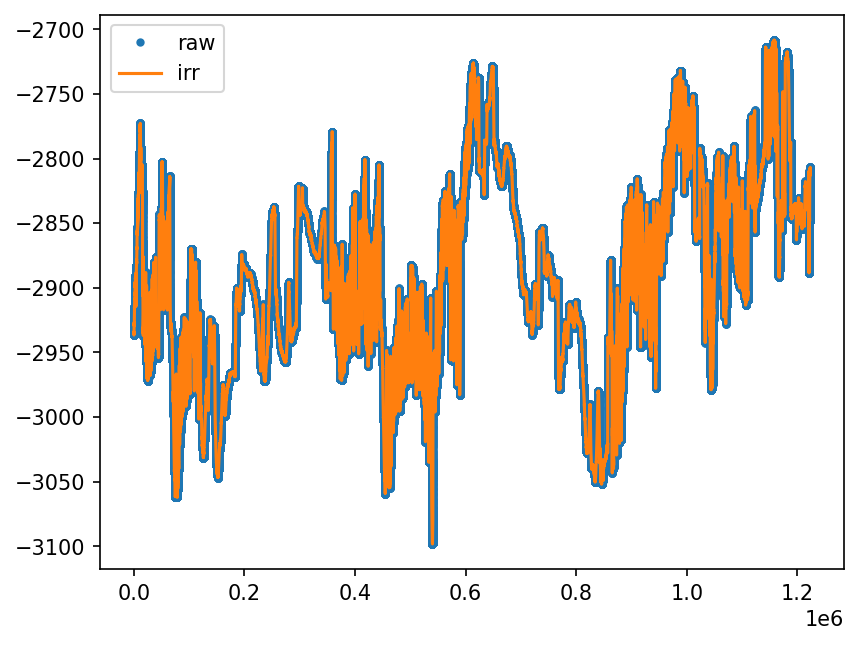

In [175]:
order = 2
Wn= (1/175)*2*math.pi
fs=1

b, a = signal.iirfilter(4, Wn=Wn, fs=fs, btype="low", ftype="butter")
gravity_filtered_irr = signal.lfilter(b, a, gravity.values)

# butter
#b, a = signal.butter(order, Wn, 'low', analog=True)
#gravity_filtered = signal.lfilter(b, a, gravity.values)

# bessel
b_bessel, a_bessel = signal.bessel(order, Wn, btype ='low', analog=True)
gravity_filtered_bessel = signal.lfilter(b_bessel, a_bessel, gravity.values)

b_bessel, a_bessel = signal.bessel(4, Wn, btype ='low')#, analog=True)
#gravity_filtered_bessel = signal.lfilter(b_bessel, a_bessel, gravity_filtered_bessel)

b_bessel, a_bessel = signal.bessel(4, Wn, btype ='low')#, analog=True)
#gravity_filtered_bessel = signal.lfilter(b_bessel, a_bessel, gravity_filtered_bessel)


start_index=10000#50000
end_index=-1#200000
fig, ax = plt.subplots()
ax.plot(gravity.values[start_index:end_index],'.', label='raw')
ax.plot(gravity_filtered_irr[start_index:end_index], label='irr')
#ax.plot(gravity_filtered_bessel[start_index:end_index], label='bessel')
ax.legend()
#plt.plot(gravity_filtered[500:])

12

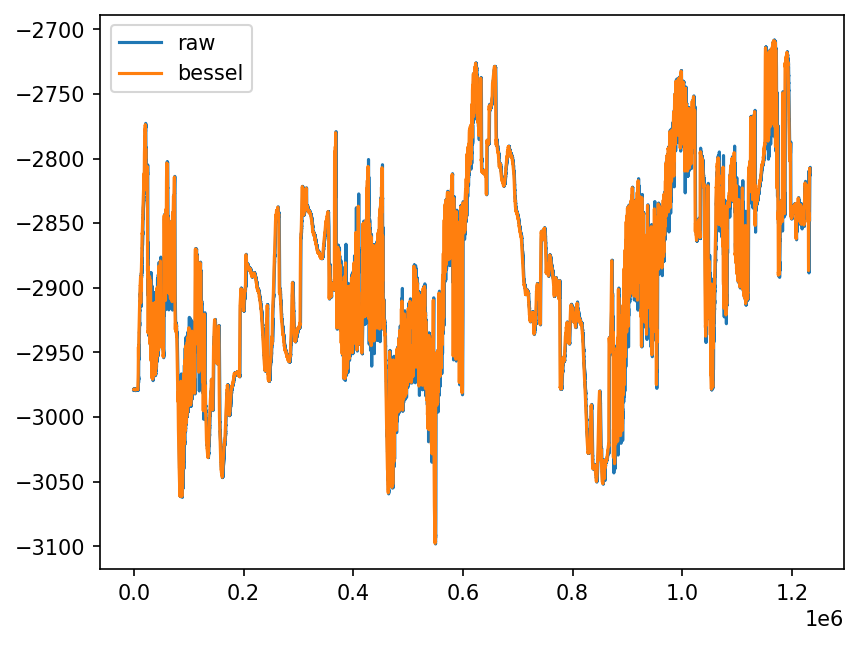

In [176]:
# [1] filtre du premier ordre (Bessel): Y(t) = X(t)*A0*V1 + Y(t-1)*B1
def bessel_1(input_arr):
    fs =1
    fc = 1/301
    fc_2pi = fc * 2*math.pi
    a0 = 1

    V1 = 1
    A0 = 1/(1+(fs*a0)/fc_rad_sec)
    B1 = 1/(1+fc_rad_sec/(fs*a0))
    
    output = np.empty(len(input_arr))
    for i in range(1,len(input_arr)):
        output[i] = input_arr[i]*A0*V1+output[i-1]*B1
    return output

# [2] premier filtre du second ordre (Bessel): Y(t) = X(t)*A1*V1+Y(t-1)*B2+Y(t-2)*B3
def bessel_2(input_arr, fs, fc, a, b):
    fc_2pi = fc * 2*math.pi
    V = 1
    A1 = 1/(1+(fs*a)/(fc_2pi) + (fs**2*b)/(fc_2pi**2));
    B2 = A1*(fs*a/fc_2pi+fs**2*b*2/fc_2pi**2);
    B3 = -A1*fs**2*b/fc_2pi**2;
    
    output = np.empty(len(input_arr))
    for i in range(2,len(input_arr)):
        output[i] = input_arr[i]*A1*V1+output[i-1]*B2+output[i-2]*B3;
    return output

def bessel_2_1(input_arr) :
    return bessel_2(input_arr, fs = 1, fc = 1/175, a = 1.3397, b = 0.4889)

# [3] deuxième filtre du second ordre (Bessel)
def bessel_2_2(input_arr) :
    return bessel_2(input_arr, fs = 1, fc = 1/175, a = 0.7743, b = 0.3890)

grav_filt = bessel_2_2(bessel_2_1(bessel_1(gravity.values)))


fig, ax = plt.subplots()
ax.plot(gravity.values, label='raw')
ax.plot(grav_filt[1000:], label='bessel')
ax.legend()

In [200]:
i_path = 'C:\\Users\\gbillant\\AppData\\Local\\Temp\\LargeArray_ce_1220174480449527291.tmp'
file_arr = np.fromfile(i_path, np.float64)
len(np.flatnonzero(np.isnan(file_arr)))

37771

In [23]:
ar = np.where(np.isnan(input_arr))[0]
len(ar)

37771

In [137]:
   
a = np.array([1,2,8,6,3,np.nan,5, np.nan,np.nan,8,6,4,4,6,15,80,np.nan,6,7])
nan_indexes = np.where(np.isnan(a))[0]


def savgol_filter_with_nan(i_arr, order=2, window_size=11):
    # split array at each NaN 
    nan_indexes = np.where(np.isnan(i_arr))[0]
    section_list = [x[~np.isnan(x)] for x in np.split(i_arr,nan_indexes)]


    # apply filtering by section
    window_size = 3
    filtered_section = [(signal.savgol_filter(a, window_size, 2) if a.size > window_size else a) for a in section_list]

    # return one arr
    print(type(filtered_section[0]))
    return np.concatenate(filtered_section)
    
print(a)
r = savgol_filter_with_nan(a) + 10
print(r)
    


[ 1.  2.  8.  6.  3. nan  5. nan nan  8.  6.  4.  4.  6. 15. 80. nan  6.
  7.]
<class 'numpy.ndarray'>
[11. 12. 18. 16. 13. 15. 18. 16. 14. 14. 16. 25. 90. 16. 17.]


In [178]:
a = np.array([1,2,8,6,3,np.nan,5, np.nan,np.nan,8,6,4,4,6,15,80,np.nan,6,7])
mask = np.isnan(a)
np.flatnonzero(np.isnan(a))
print(a)
print(~mask)
print(a[~mask])
np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), a[~mask])

[ 1.  2.  8.  6.  3. nan  5. nan nan  8.  6.  4.  4.  6. 15. 80. nan  6.
  7.]
[ True  True  True  True  True False  True False False  True  True  True
  True  True  True  True False  True  True]
[ 1.  2.  8.  6.  3.  5.  8.  6.  4.  4.  6. 15. 80.  6.  7.]


array([ 4.,  6.,  7., 43.])

In [181]:
i_arr = np.array([1,2,8,6,3,np.nan,5, np.nan,np.nan,8,6,4,4,6,15,80,np.nan,6,7])
print(i_arr)
# fill NaN by interpolation
mask = np.isnan(i_arr)
nan_indexes = np.flatnonzero(mask)
i_arr[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), i_arr[~mask])
    
result = signal.savgol_filter(i_arr, 3, 2) +10
    
result[nan_indexes] = np.nan
print(nan_indexes)
print(result)

[ 1.  2.  8.  6.  3. nan  5. nan nan  8.  6.  4.  4.  6. 15. 80. nan  6.
  7.]
[ 5  7  8 16]
[11. 12. 18. 16. 13. nan 15. nan nan 18. 16. 14. 14. 16. 25. 90. nan 16.
 17.]


In [163]:
nan_indexes=np.where(np.isnan(a))[0]

print(nan_indexes)
#f = np.insert(r,nan_indexes,np.nan)

f = r
for i in nan_indexes:
    f = np.insert(f, i, np.nan)

a2 = a
mask = np.isnan(a2)
a2[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), a2[~mask])


    
    
#b = np.where(np.isnan(a),a,r)
print(a)
print(r)
print(f)

[ 5  7  8 16]


NameError: name 'data' is not defined

In [154]:
np.isnan(a).nonzero()[0]

array([ 5,  7,  8, 16], dtype=int64)

In [42]:
signal.savgol_filter(a, 3, 2, mode='mirror')

array([ 1.,  2., nan, nan, nan, nan, nan, nan,  6.,  4.,  4.,  6., 15.,
       80.,  6.,  7.])

In [24]:
input_arr_valid = input_arr[~np.isnan(input_arr)]
print(sum(np.isnan(input_arr)))
input_arr_valid

37771


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -4.21435483e-01, -1.12587358e-01,  6.03961092e-07])

In [90]:
filtered = signal.savgol_filter(input_arr_valid, 31, 2)
filtered_by_section = savgol_filter_with_nan(input_arr, 501, 4)

In [86]:
filtered_by_section

array([ 0.00000000e+00,  0.00000000e+00,  9.62408074e-23, ...,
       -4.21435483e-01, -1.12587358e-01,  6.03961093e-07])

NaN values : 0


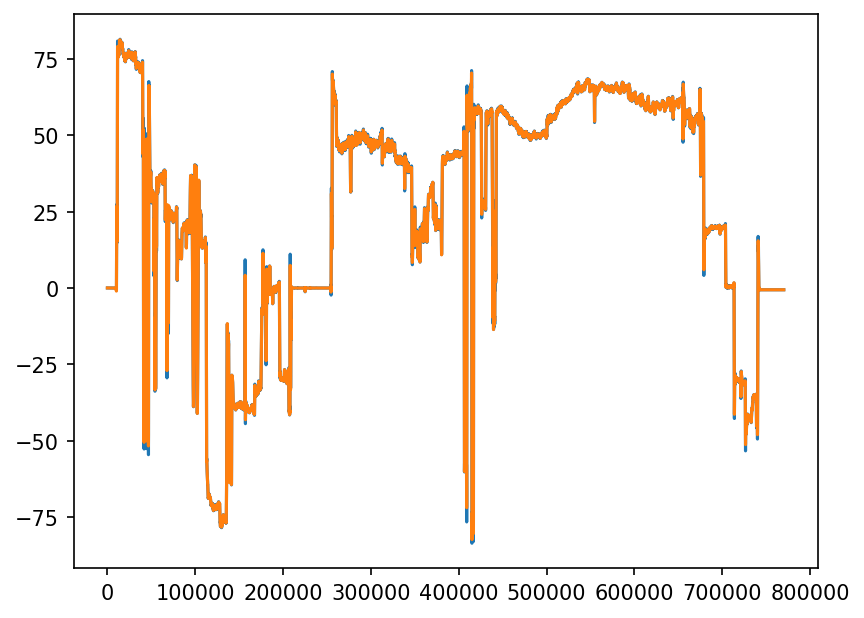

In [202]:
def savgol_filter_with_nan_2(i_arr, window_length, polyorder):
    result = i_arr
    # fill NaN by interpolation
    mask = np.isnan(i_arr)
    nan_indexes = np.flatnonzero(mask)
    result[mask] = np.interp(nan_indexes, np.flatnonzero(~mask), i_arr[~mask])
    
    # apply filter
    result = signal.savgol_filter(result, window_length, polyorder)
    
    # re-insert NaN
    result[nan_indexes] = np.nan
    return result
    

def savgol_filter_with_nan(i_arr, window_length, polyorder):
    # split array at each NaN 
    nan_mask = np.isnan(i_arr)
    nan_indexes = np.flatnonzero(nan_mask)
    print(f'NaN values : {len(nan_indexes)}')
    section_list = [x[~np.isnan(x)] for x in np.split(i_arr,nan_indexes)]

    # apply filter for each section
    filtered_section = [(signal.savgol_filter(a, window_length, polyorder) if a.size > window_length else a) for a in section_list]

    # concatenates sections in one array
    filtered_arr = np.concatenate(filtered_section)
    
    # build result array with filtered data
    result = i_arr
    result[~nan_mask] = filtered_arr
    return result

input_arr = file_arr#[50000:60000]
#input_arr[:1000] = np.nan

window_length = 501
polyorder = 2
filtered = signal.savgol_filter(input_arr[~np.isnan(input_arr)], window_length=window_length, polyorder=polyorder)
filtered_by_section = savgol_filter_with_nan(input_arr, window_length=window_length, polyorder=polyorder)
filtered_2 = savgol_filter_with_nan_2(input_arr, window_length=window_length, polyorder=polyorder)

fig, ax = plt.subplots()
ax.plot(input_arr, label='raw')
#ax.plot(filtered, label='raw')
ax.plot(filtered_2)